# Testing Dataloader Statistics

This notebook tests different normalization types and analyzes the distribution of values in the dataset.

In [1]:
import sys
sys.path.append('/mnt/nas05/data01/francesco/progetto_simone/ionosphere')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.dataset import IonoSequenceDataset
from tqdm import tqdm

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

/mnt/nas05/data01/francesco/progetto_simone/ionosphere/src/vit.py:26: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


## 1. Load Dataset with Different Normalization Types

In [2]:
# Configuration
csv_path = "/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/l1_earth_associated_with_maps.csv"
sequence_length = 30
min_center_distance = 5

# Load dataset with absolute_max normalization
print("Loading dataset with absolute_max normalization...")
dataset_abs = IonoSequenceDataset(
    csv_path=csv_path,
    transform_cond_csv=None,
    sequence_length=sequence_length,
    split='train',
    transforms=True,
    normalization_type="absolute_max",
    use_l1_conditions=True,
    min_center_distance=min_center_distance,
    seed=42
)

print(f"\nDataset size (absolute_max): {len(dataset_abs)} sequences")
print(f"Condition min values: {dataset_abs.cond_min}")
print(f"Condition max values: {dataset_abs.cond_max}")

Loading dataset with absolute_max normalization...

Dataset size (absolute_max): 29124 sequences
Condition min values: [-821.7   -32.58  -71.9   -50.93]
Condition max values: [-252.9    25.8    73.45   64.24]


In [3]:
# Load dataset with mean_sigma_tanh normalization
print("Loading dataset with mean_sigma_tanh normalization...")
dataset_tanh = IonoSequenceDataset(
    csv_path=csv_path,
    transform_cond_csv=None,
    sequence_length=sequence_length,
    split='train',
    transforms=True,
    normalization_type="mean_sigma_tanh",
    use_l1_conditions=True,
    min_center_distance=min_center_distance,
    seed=42
)

print(f"\nDataset size (mean_sigma_tanh): {len(dataset_tanh)} sequences")
if dataset_tanh.normalizer is not None:
    stats = dataset_tanh.normalizer.get_stats()
    print(f"Normalizer mean: {stats['mean']:.2f}")
    print(f"Normalizer std: {stats['std']:.2f}")

Loading dataset with mean_sigma_tanh normalization...
Fitting sequence normalizer on 10 sequences...
Sequence normalizer fitted: mean=-3103.39, std=7220.04

Dataset size (mean_sigma_tanh): 29124 sequences
Normalizer mean: -3103.39
Normalizer std: 7220.04


## 2. Sample Data and Analyze Ranges

In [4]:
# Sample from both datasets
num_samples = min(100, len(dataset_abs))

print(f"Collecting statistics from {num_samples} sequences...")

# Collect data values
data_abs_values = []
data_tanh_values = []
cond_normalized_values = []
cond_original_values = []
missing_frame_counts = []

for i in tqdm(range(num_samples)):
    # Absolute max normalization
    data_seq_abs, cond_seq = dataset_abs[i]
    
    # Filter out missing frames (cond == 2.0)
    valid_mask = ~(cond_seq[:, 0] == 2.0)
    missing_count = (~valid_mask).sum().item()
    missing_frame_counts.append(missing_count)
    
    # Collect data values (only valid frames)
    data_abs_values.extend(data_seq_abs[valid_mask].flatten().numpy())
    
    # Collect condition values (only valid frames)
    cond_normalized_values.extend(cond_seq[valid_mask].flatten().numpy())
    
    # Revert normalization for original values
    if valid_mask.sum() > 0:
        cond_orig = dataset_abs.revert_condition_normalization(cond_seq[valid_mask])
        cond_original_values.extend(cond_orig.flatten().numpy())
    
    # Mean-sigma-tanh normalization
    data_seq_tanh, _ = dataset_tanh[i]
    data_tanh_values.extend(data_seq_tanh[valid_mask].flatten().numpy())

# Convert to numpy arrays
data_abs_values = np.array(data_abs_values)
data_tanh_values = np.array(data_tanh_values)
cond_normalized_values = np.array(cond_normalized_values)
cond_original_values = np.array(cond_original_values)

print(f"\nCollected {len(data_abs_values):,} data points")
print(f"Average missing frames per sequence: {np.mean(missing_frame_counts):.2f}")

100%|██████████| 100/100 [02:02<00:00,  1.23s/it]



Collected 12,588,480 data points
Average missing frames per sequence: 15.43


## 3. Statistical Summary

In [5]:
print("="*80)
print("STATISTICAL SUMMARY")
print("="*80)

print("\n📊 DATA VALUES (Ionosphere Maps)")
print("-" * 80)
print(f"Absolute Max Normalization:")
print(f"  Min:     {data_abs_values.min():.6f}")
print(f"  Max:     {data_abs_values.max():.6f}")
print(f"  Mean:    {data_abs_values.mean():.6f}")
print(f"  Median:  {np.median(data_abs_values):.6f}")
print(f"  Std:     {data_abs_values.std():.6f}")
print(f"  Q1:      {np.percentile(data_abs_values, 25):.6f}")
print(f"  Q3:      {np.percentile(data_abs_values, 75):.6f}")

print(f"\nMean-Sigma-Tanh Normalization:")
print(f"  Min:     {data_tanh_values.min():.6f}")
print(f"  Max:     {data_tanh_values.max():.6f}")
print(f"  Mean:    {data_tanh_values.mean():.6f}")
print(f"  Median:  {np.median(data_tanh_values):.6f}")
print(f"  Std:     {data_tanh_values.std():.6f}")
print(f"  Q1:      {np.percentile(data_tanh_values, 25):.6f}")
print(f"  Q3:      {np.percentile(data_tanh_values, 75):.6f}")

print("\n🌐 CONDITIONS (L1 Solar Wind Parameters)")
print("-" * 80)
print(f"Normalized Conditions (should be in [-1, 1]):")
print(f"  Min:     {cond_normalized_values.min():.6f}")
print(f"  Max:     {cond_normalized_values.max():.6f}")
print(f"  Mean:    {cond_normalized_values.mean():.6f}")
print(f"  Median:  {np.median(cond_normalized_values):.6f}")
print(f"  Std:     {cond_normalized_values.std():.6f}")

print(f"\nOriginal Condition Values (denormalized):")
print(f"  Min:     {cond_original_values.min():.2f}")
print(f"  Max:     {cond_original_values.max():.2f}")
print(f"  Mean:    {cond_original_values.mean():.2f}")
print(f"  Median:  {np.median(cond_original_values):.2f}")
print(f"  Std:     {cond_original_values.std():.2f}")

print("\n🚫 MISSING FRAMES")
print("-" * 80)
print(f"Total sequences analyzed: {num_samples}")
print(f"Average missing frames per sequence: {np.mean(missing_frame_counts):.2f}")
print(f"Min missing frames: {np.min(missing_frame_counts)}")
print(f"Max missing frames: {np.max(missing_frame_counts)}")
print(f"Sequences with no missing frames: {np.sum(np.array(missing_frame_counts) == 0)}")

STATISTICAL SUMMARY

📊 DATA VALUES (Ionosphere Maps)
--------------------------------------------------------------------------------
Absolute Max Normalization:
  Min:     -0.830303
  Max:     0.593964
  Mean:    -0.126111
  Median:  -0.087748
  Std:     0.180547
  Q1:      -0.260327
  Q3:      0.002011

Mean-Sigma-Tanh Normalization:
  Min:     -0.999985
  Max:     0.999901
  Mean:    -0.190028
  Median:  -0.234180
  Std:     0.681354
  Q1:      -0.914322
  Q3:      0.417901

🌐 CONDITIONS (L1 Solar Wind Parameters)
--------------------------------------------------------------------------------
Normalized Conditions (should be in [-1, 1]):
  Min:     -0.269613
  Max:     8.087957
  Mean:    1.871570
  Median:  1.062760
  Std:     2.319705

Original Condition Values (denormalized):
  Min:     -11.26
  Max:     472.40
  Mean:    81.42
  Median:  -0.48
  Std:     144.75

🚫 MISSING FRAMES
--------------------------------------------------------------------------------
Total sequences ana

## 4. Distribution Plots

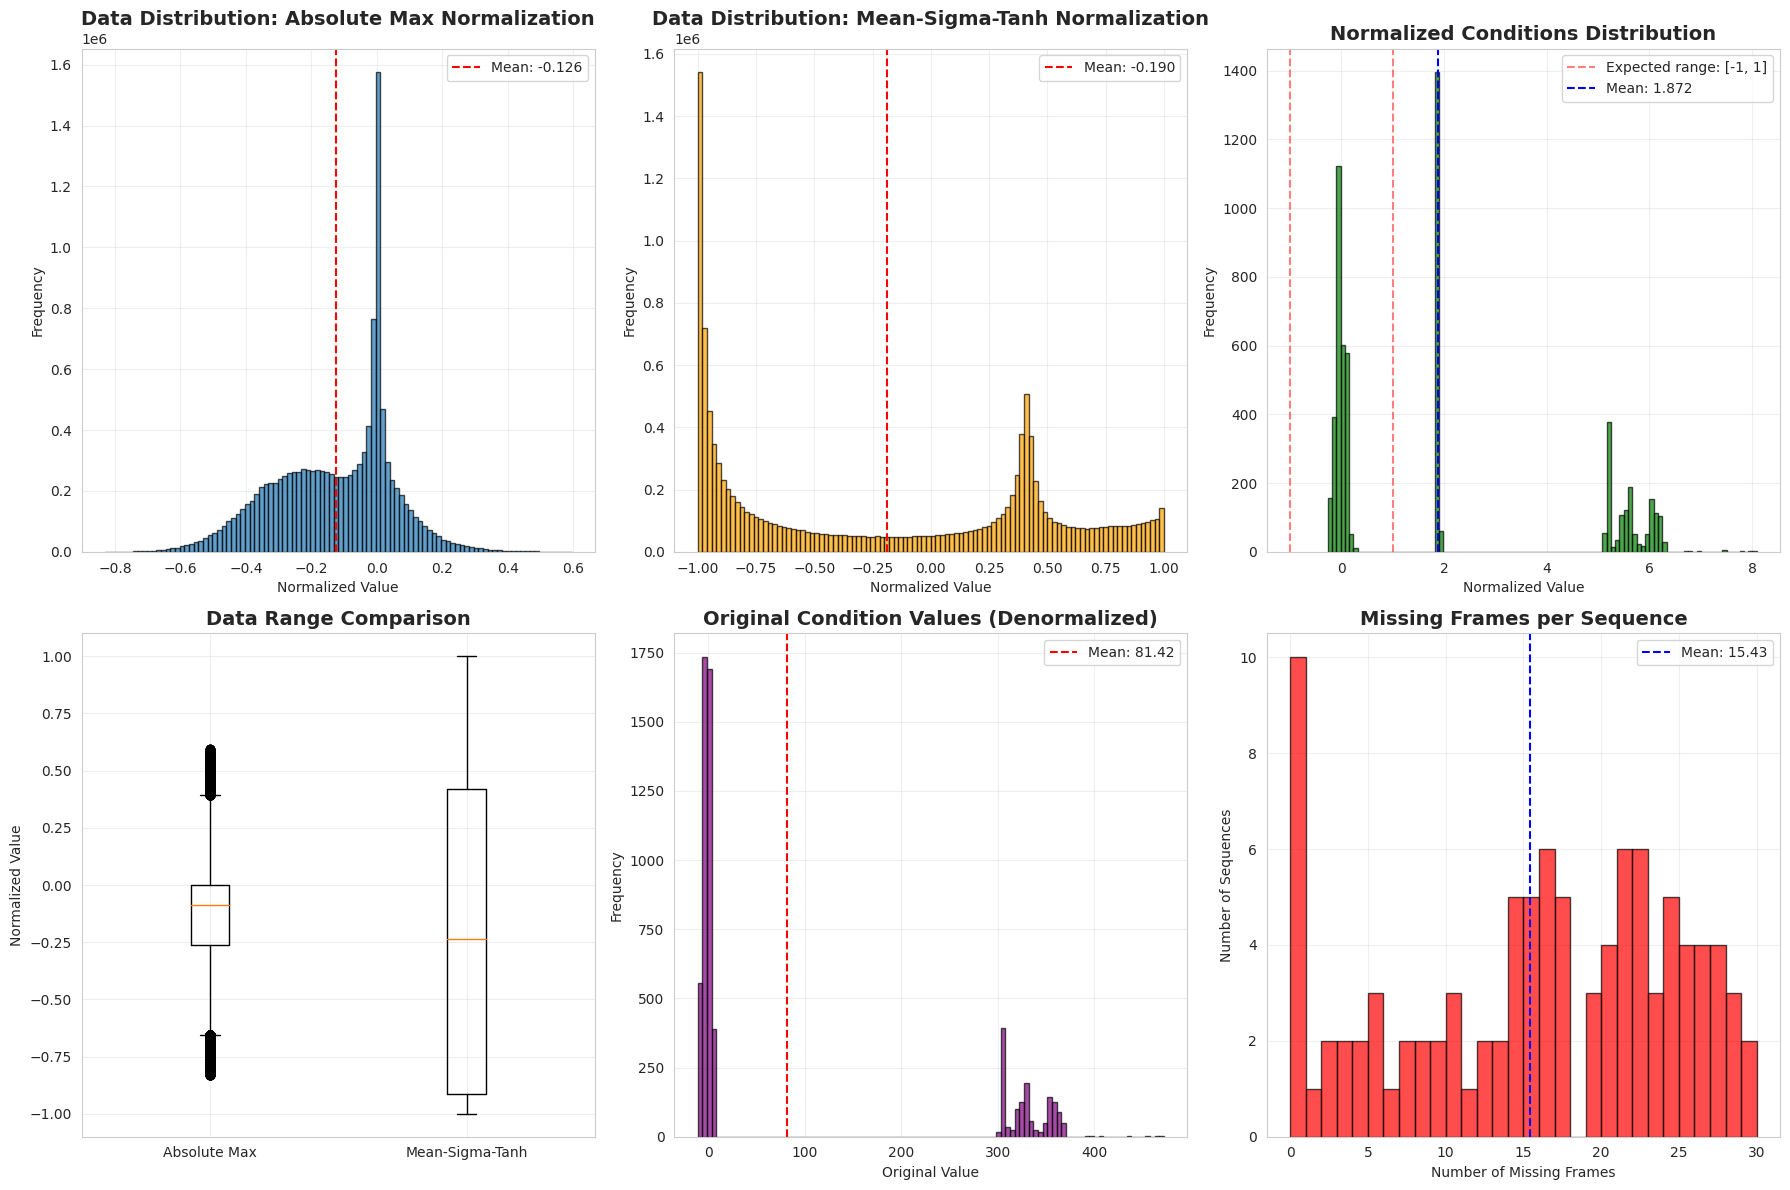

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Absolute max normalized data histogram
axes[0, 0].hist(data_abs_values, bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Data Distribution: Absolute Max Normalization', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Normalized Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(data_abs_values.mean(), color='red', linestyle='--', label=f'Mean: {data_abs_values.mean():.3f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Mean-sigma-tanh normalized data histogram
axes[0, 1].hist(data_tanh_values, bins=100, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].set_title('Data Distribution: Mean-Sigma-Tanh Normalization', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Normalized Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(data_tanh_values.mean(), color='red', linestyle='--', label=f'Mean: {data_tanh_values.mean():.3f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Normalized conditions histogram
axes[0, 2].hist(cond_normalized_values, bins=100, alpha=0.7, color='green', edgecolor='black')
axes[0, 2].set_title('Normalized Conditions Distribution', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Normalized Value')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(-1, color='red', linestyle='--', alpha=0.5, label='Expected range: [-1, 1]')
axes[0, 2].axvline(1, color='red', linestyle='--', alpha=0.5)
axes[0, 2].axvline(cond_normalized_values.mean(), color='blue', linestyle='--', label=f'Mean: {cond_normalized_values.mean():.3f}')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Box plot comparison of normalizations
box_data = [data_abs_values, data_tanh_values]
axes[1, 0].boxplot(box_data, labels=['Absolute Max', 'Mean-Sigma-Tanh'])
axes[1, 0].set_title('Data Range Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Normalized Value')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Original condition values histogram
axes[1, 1].hist(cond_original_values, bins=100, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('Original Condition Values (Denormalized)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Original Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(cond_original_values.mean(), color='red', linestyle='--', label=f'Mean: {cond_original_values.mean():.2f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Missing frames distribution
axes[1, 2].hist(missing_frame_counts, bins=range(0, max(missing_frame_counts)+2), alpha=0.7, color='red', edgecolor='black')
axes[1, 2].set_title('Missing Frames per Sequence', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Number of Missing Frames')
axes[1, 2].set_ylabel('Number of Sequences')
axes[1, 2].axvline(np.mean(missing_frame_counts), color='blue', linestyle='--', label=f'Mean: {np.mean(missing_frame_counts):.2f}')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/mnt/nas05/data01/francesco/progetto_simone/ionosphere/notebook/normalization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Per-Condition Analysis (L1 Parameters)

In [7]:
# Sample sequences and separate by condition type
bx_values, by_values, bz_values, vx_values = [], [], [], []
bx_norm, by_norm, bz_norm, vx_norm = [], [], [], []

for i in range(num_samples):
    data_seq, cond_seq = dataset_abs[i]
    
    # Filter out missing frames
    valid_mask = ~(cond_seq[:, 0] == 2.0)
    
    if valid_mask.sum() > 0:
        # Normalized values
        bx_norm.extend(cond_seq[valid_mask, 0].numpy())
        by_norm.extend(cond_seq[valid_mask, 1].numpy())
        bz_norm.extend(cond_seq[valid_mask, 2].numpy())
        vx_norm.extend(cond_seq[valid_mask, 3].numpy())
        
        # Original values
        cond_orig = dataset_abs.revert_condition_normalization(cond_seq[valid_mask])
        bx_values.extend(cond_orig[:, 0].numpy())
        by_values.extend(cond_orig[:, 1].numpy())
        bz_values.extend(cond_orig[:, 2].numpy())
        vx_values.extend(cond_orig[:, 3].numpy())

# Convert to numpy arrays
bx_values = np.array(bx_values)
by_values = np.array(by_values)
bz_values = np.array(bz_values)
vx_values = np.array(vx_values)

bx_norm = np.array(bx_norm)
by_norm = np.array(by_norm)
bz_norm = np.array(bz_norm)
vx_norm = np.array(vx_norm)

In [ ]:
# Plot individual condition distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Original values
axes[0, 0].hist(bx_values, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title(f'Bx GSM (Original)\nMean: {bx_values.mean():.2f}, Std: {bx_values.std():.2f}', fontweight='bold')
axes[0, 0].set_xlabel('nT')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(by_values, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title(f'By GSM (Original)\nMean: {by_values.mean():.2f}, Std: {by_values.std():.2f}', fontweight='bold')
axes[0, 1].set_xlabel('nT')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(bz_values, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0, 2].set_title(f'Bz GSM (Original)\nMean: {bz_values.mean():.2f}, Std: {bz_values.std():.2f}', fontweight='bold')
axes[0, 2].set_xlabel('nT')
axes[0, 2].grid(True, alpha=0.3)

axes[0, 3].hist(vx_values, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 3].set_title(f'Vx GSM (Original)\nMean: {vx_values.mean():.2f}, Std: {vx_values.std():.2f}', fontweight='bold')
axes[0, 3].set_xlabel('km/s')
axes[0, 3].grid(True, alpha=0.3)

# Normalized values
axes[1, 0].hist(bx_norm, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].set_title(f'Bx GSM (Normalized)\nRange: [{bx_norm.min():.2f}, {bx_norm.max():.2f}]', fontweight='bold')
axes[1, 0].set_xlabel('Normalized')
axes[1, 0].axvline(-1, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axvline(1, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(by_norm, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].set_title(f'By GSM (Normalized)\nRange: [{by_norm.min():.2f}, {by_norm.max():.2f}]', fontweight='bold')
axes[1, 1].set_xlabel('Normalized')
axes[1, 1].axvline(-1, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axvline(1, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].hist(bz_norm, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1, 2].set_title(f'Bz GSM (Normalized)\nRange: [{bz_norm.min():.2f}, {bz_norm.max():.2f}]', fontweight='bold')
axes[1, 2].set_xlabel('Normalized')
axes[1, 2].axvline(-1, color='red', linestyle='--', alpha=0.5)
axes[1, 2].axvline(1, color='red', linestyle='--', alpha=0.5)
axes[1, 2].grid(True, alpha=0.3)

axes[1, 3].hist(vx_norm, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 3].set_title(f'Vx GSM (Normalized)\nRange: [{vx_norm.min():.2f}, {vx_norm.max():.2f}]', fontweight='bold')
axes[1, 3].set_xlabel('Normalized')
axes[1, 3].axvline(-1, color='red', linestyle='--', alpha=0.5)
axes[1, 3].axvline(1, color='red', linestyle='--', alpha=0.5)
axes[1, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/mnt/nas05/data01/francesco/progetto_simone/ionosphere/notebook/condition_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Print Summary Table

In [ ]:
# Create a summary dataframe
summary_data = {
    'Parameter': ['Bx GSM', 'By GSM', 'Bz GSM', 'Vx GSM'],
    'Min (original)': [bx_values.min(), by_values.min(), bz_values.min(), vx_values.min()],
    'Max (original)': [bx_values.max(), by_values.max(), bz_values.max(), vx_values.max()],
    'Mean (original)': [bx_values.mean(), by_values.mean(), bz_values.mean(), vx_values.mean()],
    'Std (original)': [bx_values.std(), by_values.std(), bz_values.std(), vx_values.std()],
    'Min (normalized)': [bx_norm.min(), by_norm.min(), bz_norm.min(), vx_norm.min()],
    'Max (normalized)': [bx_norm.max(), by_norm.max(), bz_norm.max(), vx_norm.max()],
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*100)
print("L1 CONDITION PARAMETERS SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

## 7. Visualize Sample Sequence

In [ ]:
# Visualize a sample sequence with both normalizations
sample_idx = 0
data_seq_abs, cond_seq = dataset_abs[sample_idx]
data_seq_tanh, _ = dataset_tanh[sample_idx]

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

# Plot 5 frames from the sequence
frame_indices = np.linspace(0, len(data_seq_abs)-1, 5, dtype=int)

for idx, frame_idx in enumerate(frame_indices):
    # Absolute max normalization
    frame_abs = data_seq_abs[frame_idx, 0].numpy()
    im1 = axes[0, idx].imshow(frame_abs, cmap='plasma', aspect='auto', vmin=-1, vmax=1)
    axes[0, idx].set_title(f'Frame {frame_idx} (Abs Max)', fontweight='bold')
    axes[0, idx].axis('off')
    plt.colorbar(im1, ax=axes[0, idx], fraction=0.046)
    
    # Mean-sigma-tanh normalization
    frame_tanh = data_seq_tanh[frame_idx, 0].numpy()
    im2 = axes[1, idx].imshow(frame_tanh, cmap='plasma', aspect='auto', vmin=-1, vmax=1)
    axes[1, idx].set_title(f'Frame {frame_idx} (Tanh)', fontweight='bold')
    axes[1, idx].axis('off')
    plt.colorbar(im2, ax=axes[1, idx], fraction=0.046)
    
    # Show conditions
    cond = cond_seq[frame_idx].numpy()
    is_missing = np.all(cond == 2.0)
    
    if is_missing:
        axes[2, idx].text(0.5, 0.5, 'MISSING FRAME', ha='center', va='center', 
                         fontsize=12, fontweight='bold', color='red',
                         transform=axes[2, idx].transAxes)
    else:
        cond_text = f'Bx: {cond[0]:.2f}\nBy: {cond[1]:.2f}\nBz: {cond[2]:.2f}\nVx: {cond[3]:.2f}'
        axes[2, idx].text(0.5, 0.5, cond_text, ha='center', va='center',
                         fontsize=10, fontweight='bold',
                         transform=axes[2, idx].transAxes,
                         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    axes[2, idx].set_xlim(0, 1)
    axes[2, idx].set_ylim(0, 1)
    axes[2, idx].axis('off')
    axes[2, idx].set_title('Conditions (normalized)', fontweight='bold')

plt.suptitle(f'Sample Sequence {sample_idx} - Normalization Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/mnt/nas05/data01/francesco/progetto_simone/ionosphere/notebook/sample_sequence.png', dpi=150, bbox_inches='tight')
plt.show()